Start with importing everything that will be needed for this notebook.

In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench.em_framework.optimization import EpsilonProgress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
from ema_workbench import Policy
import seaborn as sns
from ema_workbench import save_results
from ema_workbench import ScalarOutcome


Imports the model with our chosen problem formulution. Also add a reference scenario for the mordor analysis the normal values from the model.

In [2]:
model, planning_steps = get_model_for_problem_formulation(3)


reference_scenario = Scenario('reference', **{'A.0_ID flood wave shape': 4,
                                              'A.1_Bmax': 175, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 175, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 175, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 175, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 175, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})


Sets the values for the analysis that will be done. A high epsilon was chosen because the model didn't want to converge with high values with a low epison took to long to converge

In [3]:
convergence_metrics = [EpsilonProgress()]
nfe = 100000
epsilon = [0.5,] * len(model.outcomes)

Runs the analysis

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon, reference= reference_scenario, convergence  = convergence_metrics )

[MainProcess/INFO] pool started with 12 workers
  3%|▉                                 | 2892/100000 [05:32<3:16:04,  8.25it/s]

KeyboardInterrupt: 

Saves the results as a data frame.

In [5]:
df, convergence = total

In [6]:
print(len(df))

4128


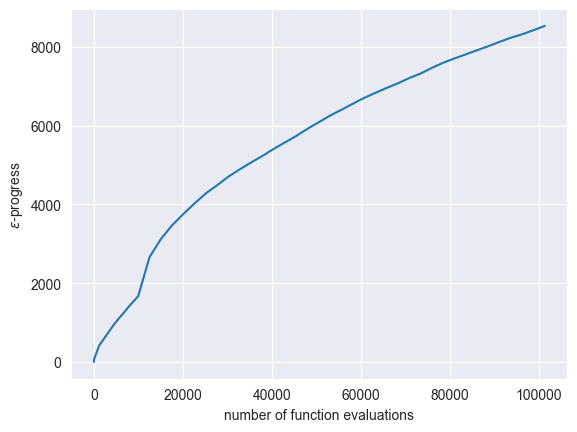

In [7]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

as can be seen it begins to slowly converge but not a lot, because of the many runs there could porbably be played with it for beter results

In [8]:
from ema_workbench import save_results
df, convergence = total


In [9]:
df['sum_deaths'] = df['A.1_Expected Number of Deaths'] + df['A.2_Expected Number of Deaths'] + df['A.3_Expected Number of Deaths'] + df['A.4_Expected Number of Deaths'] + df['A.5_Expected Number of Deaths']
df["sum_costs"]= df["A.3 Total Costs"] + df["A.2 Total Costs"] + df["A.1 Total Costs"] + df["A.4 Total Costs"] + df["A.5 Total Costs"]

df.to_csv('MORDOR small.csv') #save as csv for quicker recovery later

8

Run parcoords with 4000+ policies

C:\Users\Alex\PycharmProjects\Model_based_decision\venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


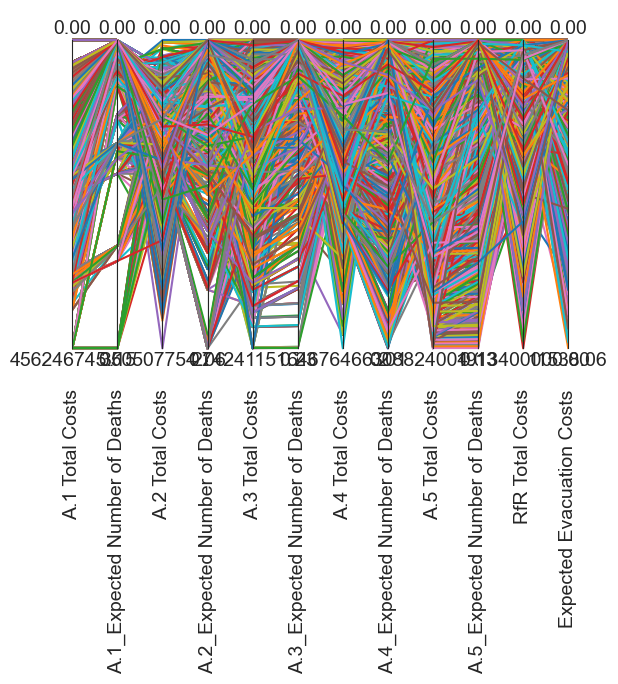

In [15]:
data = df.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0 #sets lower bound to zero
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns) #reverses the x because minimizing is the goal
plt.show()

In [11]:
df = pd.read_csv('MORDOR small.csv')  # reads the csv

limiting = (df.sum_deaths < 0.0001) & (df.sum_costs < 450000000) # finds policies with low death and cost
np.sum(limiting) # counts the amount of policies with those limits


8

Repeat parcoords with less policies for a clearer view

C:\Users\Alex\PycharmProjects\Model_based_decision\venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


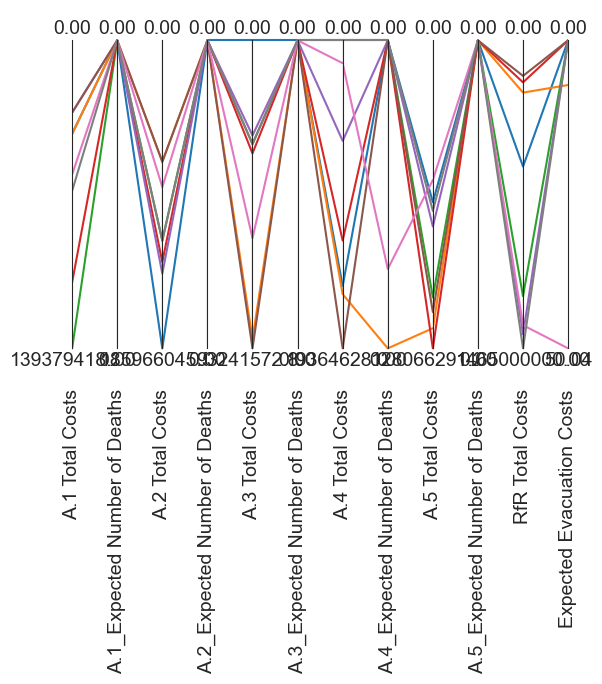

In [16]:
data = df[limiting].loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns)
plt.show()

In [26]:
df[limiting]
display(df[limiting]) # displays the policies and results

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,sum_deaths,sum_costs
458,458,0,1,1,1,0,0,1,1,1,...,0.000000e+00,0.0,1.544456e+07,0.000000,6.726847e+07,0.0,6.003000e+08,0.000000,0.000000,3.109706e+08
466,466,0,0,0,1,0,0,1,0,0,...,9.045456e+07,0.0,1.596051e+07,0.000052,1.196971e+08,0.0,2.485000e+08,7.257396,0.000052,3.417192e+08
971,971,1,0,0,0,0,0,0,0,0,...,3.139880e+07,0.0,0.000000e+00,0.000000,1.068240e+08,0.0,1.216500e+09,0.000000,0.000000,3.984945e+08
1310,1310,1,1,0,0,0,0,0,0,1,...,3.422156e+07,0.0,1.258646e+07,0.000000,1.280663e+08,0.0,1.999000e+08,0.000000,0.000000,4.182219e+08
1317,1317,1,1,0,0,1,0,0,0,0,...,2.879840e+07,0.0,6.320800e+06,0.000000,7.740447e+07,0.0,1.397700e+09,0.000000,0.000000,2.860412e+08
3269,3269,0,1,1,0,0,0,0,0,0,...,9.324157e+07,0.0,1.936463e+07,0.000000,1.129623e+08,0.0,1.692000e+08,0.000000,0.000000,3.315789e+08
3607,3607,0,1,1,0,0,1,1,1,1,...,5.990344e+07,0.0,1.434656e+06,0.000039,5.804407e+07,0.0,1.354900e+09,50.038871,0.000039,2.687126e+08
4078,4078,0,1,0,1,0,0,1,0,0,...,3.139880e+07,0.0,0.000000e+00,0.000000,7.090316e+07,0.0,1.465000e+09,0.000000,0.000000,2.913332e+08


In [28]:
policy_advice = df[limiting]
policies = policy_advice.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop(columns= ["sum_deaths"])
policies = policies.drop(columns= ["sum_costs"])
display(policies)

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
458,458,0,1,1,1,0,0,1,1,1,...,3,0,0,0,3,0,1,3,0,4
466,466,0,0,0,1,0,0,1,0,0,...,0,3,7,1,3,0,1,6,4,2
971,971,1,0,0,0,0,0,0,0,0,...,6,6,0,0,0,0,0,1,7,2
1310,1310,1,1,0,0,0,0,0,0,1,...,0,7,0,0,6,0,0,7,5,1
1317,1317,1,1,0,0,1,0,0,0,0,...,0,5,0,0,1,0,0,6,3,0
3269,3269,0,1,1,0,0,0,0,0,0,...,0,7,3,1,4,0,3,7,2,1
3607,3607,0,1,1,0,0,1,1,1,1,...,2,0,7,1,0,0,0,3,1,0
4078,4078,0,1,0,1,0,0,1,0,0,...,6,6,0,0,0,0,0,6,0,1


In [29]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

Does a scenario analysis from those 8 policies


In [30]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
100%|██████████████████████████████████████| 8000/8000 [10:02<00:00, 13.27it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [31]:
save_results(results, 'Mordor_policy_final_results')
experiments, outcomes = results

[MainProcess/INFO] results saved successfully to C:\Users\Alex\Downloads\epa1361_open-master\epa1361_open-master\final assignment\Mordor_policy_final_results


In [43]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = np.mean(value)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
means = pd.DataFrame.from_dict(overall_scores).T
means

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
1310,1.095033e+08,0.000000,1.348806e+08,0.000853,3.751571e+07,0.006259,1.443445e+07,0.000937,1.304813e+08,0.002287,1.999000e+08,0.000000
1317,6.003117e+07,0.017839,1.418583e+08,0.000853,4.690721e+07,0.032893,1.120398e+07,0.002024,7.795364e+07,0.000518,1.397700e+09,0.000000
3269,1.573818e+08,0.080191,7.660673e+07,0.003093,9.622850e+07,0.005581,2.382548e+07,0.002224,1.155246e+08,0.002460,1.692000e+08,0.000000
3607,8.930504e+07,0.002254,1.048859e+08,0.001706,7.420229e+07,0.002898,7.378888e+06,0.000357,6.059672e+07,0.000287,1.354900e+09,2849.680333
4078,1.786868e+08,0.071394,1.360041e+08,0.013386,3.300934e+07,0.002924,4.982517e+06,0.001937,7.117906e+07,0.000269,1.465000e+09,0.000000
458,7.147844e+07,0.019120,1.956937e+08,0.008292,8.540198e+07,0.143466,2.150271e+07,0.002872,8.450493e+07,0.015889,6.003000e+08,0.000000
466,3.705597e+08,0.076240,7.547545e+07,0.000718,1.119111e+08,0.013592,2.414039e+07,0.001530,1.221418e+08,0.000857,2.485000e+08,2918.370067
971,2.102757e+08,0.045350,1.422607e+08,0.019193,3.629786e+07,0.009083,4.980198e+06,0.001933,1.113851e+08,0.004038,1.216500e+09,0.000000


In [32]:

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [33]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
1310,1.631727e+00,0.000000,1.835710e+15,0.000008,7.932768e+14,0.000263,1.373420e+14,3.905347e-06,1.538500e+15,2.354776e-05,0.0,0.000000e+00
1317,1.277726e+16,0.002512,1.839427e+15,0.000008,5.219953e+15,0.006682,1.461767e+14,9.670102e-06,3.515980e+14,2.088131e-06,0.0,0.000000e+00
3269,7.590264e+16,0.024607,2.554119e+15,0.000089,2.079507e+15,0.000220,3.561086e+14,1.463777e-05,1.813833e+15,3.586530e-05,0.0,0.000000e+00
3607,1.756621e+16,0.000034,6.893138e+15,0.000011,5.064003e+15,0.000039,1.194545e+14,2.486400e-07,8.551007e+14,4.459119e-07,0.0,1.601976e+07
4078,6.994973e+16,0.017727,8.193368e+15,0.000646,3.520961e+14,0.000057,6.167588e+13,8.114397e-06,2.455281e+14,9.006336e-07,0.0,0.000000e+00
458,1.440933e+16,0.002479,6.943115e+15,0.000222,2.448623e+16,0.067614,3.945529e+14,2.262627e-05,4.592687e+15,7.708799e-04,0.0,0.000000e+00
466,2.519637e+17,0.011854,2.020115e+15,0.000006,9.653661e+15,0.000712,5.697127e+14,5.774533e-06,1.818957e+15,4.204597e-06,0.0,1.268231e+07
971,6.160989e+16,0.008402,1.061775e+16,0.001181,1.190417e+15,0.000576,6.181002e+13,8.114691e-06,1.767049e+15,5.283028e-05,0.0,0.000000e+00


Noise parcoords

C:\Users\Alex\PycharmProjects\Model_based_decision\venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


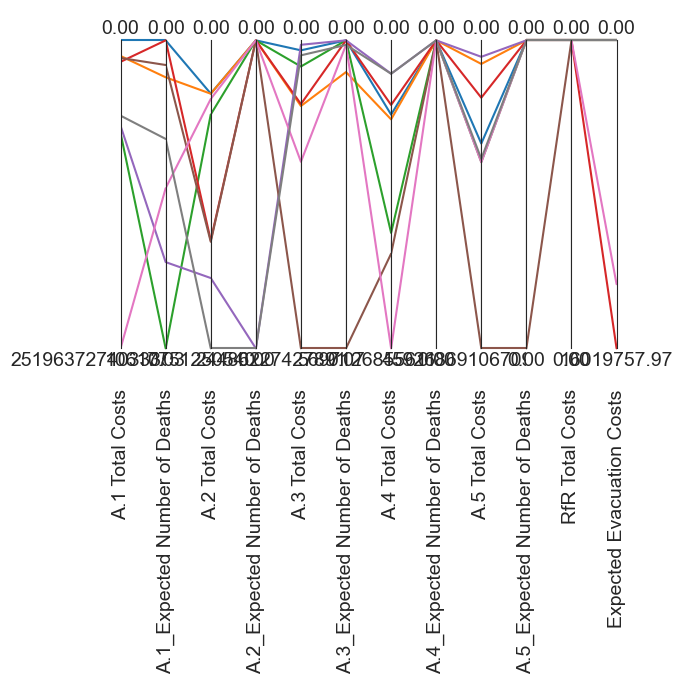

In [34]:
data = scores.round(3)
limits = parcoords.get_limits(data)
limits.loc[0, data.columns] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(scores.columns)
plt.show()

In [35]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [36]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


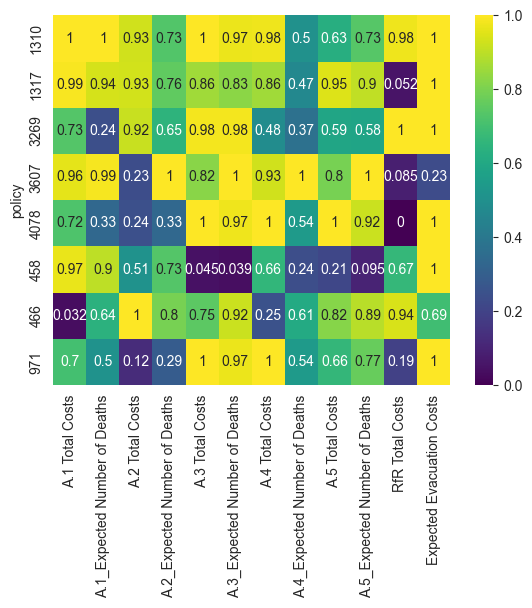

In [37]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [38]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

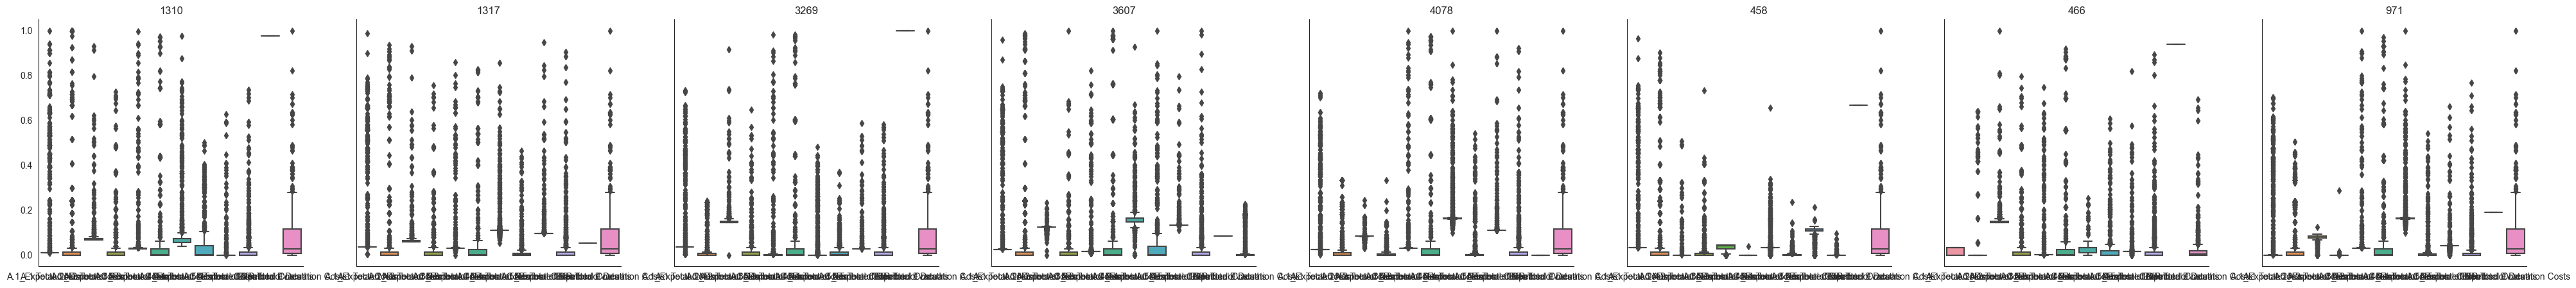

In [42]:
# this generates plots for the 8 policies with a shared y and x axis
fig, axes = plt.subplots(ncols=8, figsize=(50,5),
                         sharey=True, sharex=True)
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    sns.despine()
    ax.set_title(str(policy))
plt.savefig('8.png')
plt.show()

In [40]:
display(policies)

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
458,458,0,1,1,1,0,0,1,1,1,...,3,0,0,0,3,0,1,3,0,4
466,466,0,0,0,1,0,0,1,0,0,...,0,3,7,1,3,0,1,6,4,2
971,971,1,0,0,0,0,0,0,0,0,...,6,6,0,0,0,0,0,1,7,2
1310,1310,1,1,0,0,0,0,0,0,1,...,0,7,0,0,6,0,0,7,5,1
1317,1317,1,1,0,0,1,0,0,0,0,...,0,5,0,0,1,0,0,6,3,0
3269,3269,0,1,1,0,0,0,0,0,0,...,0,7,3,1,4,0,3,7,2,1
3607,3607,0,1,1,0,0,1,1,1,1,...,2,0,7,1,0,0,0,3,1,0
4078,4078,0,1,0,1,0,0,1,0,0,...,6,6,0,0,0,0,0,6,0,1
